<a href="https://colab.research.google.com/github/TSFelg/arboretum.link/blob/main/MLP_imdb_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
! pip install lightning==2.0.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df = pd.read_csv('/content/drive/My Drive/nos-kaggle/labeledTrainData.tsv', header=0, \
                    delimiter="\t", quoting=3)

df_shuffled = df.sample(frac=1, random_state=1).reset_index()

df_train = df_shuffled.iloc[:20000]
df_val = df_shuffled.iloc[20000:25000]

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/nos-kaggle/testData.tsv', header=0, \
                    delimiter="\t", quoting=3)

In [ ]:
cv = CountVectorizer(lowercase=True, max_features=10_000, stop_words="english")

cv.fit(df_train["review"])

X_train = cv.transform(df_train["review"])
X_val = cv.transform(df_val["review"])
X_test = cv.transform(df_test["review"])

In [ ]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.labels.shape[0]

In [ ]:
train_ds = TextDataset(X_train.todense(), df_train["sentiment"].values)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=128,
    shuffle=True,
)

In [ ]:
val_ds = TextDataset(X_val.todense(), df_val["sentiment"].values)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=128,
    shuffle=True,
)

In [ ]:
for batch_idx, (features, class_labels) in enumerate(train_loader):
    break

In [ ]:
features.shape

torch.Size([128, 10000])

In [ ]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits


pytorch_model = LogisticRegression(num_features=10_000, num_classes=2)

In [ ]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [ ]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
import torch.nn.functional as F
import torchmetrics

In [ ]:

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=30,
    accelerator="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RA

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

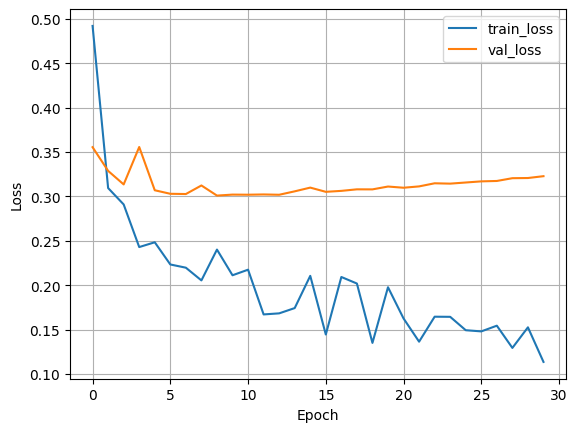

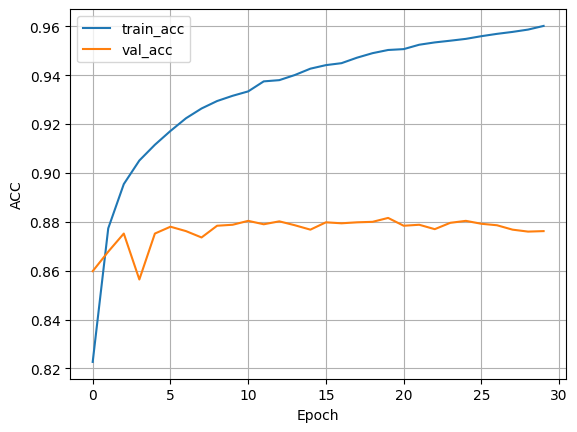

In [ ]:
plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")